In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from autoencoder import Autoencoder_cnn
from stacked_mnist import StackedMNISTData, DataMode
from verification_net import VerificationNet

import warnings
warnings.filterwarnings('ignore', category=Warning)

In [65]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=10)

In [66]:
model = Autoencoder_cnn(n_channels=1, criterion=nn.BCELoss(),latent_dim=16) #16

Epoch:1, Loss:0.3755
Epoch:2, Loss:0.2883
Epoch:3, Loss:0.2510
Epoch:4, Loss:0.2278
Epoch:5, Loss:0.2093
Epoch:6, Loss:0.1920
Epoch:7, Loss:0.1861
Epoch:8, Loss:0.1825
Epoch:9, Loss:0.1797
Epoch:10, Loss:0.1774
Epoch:11, Loss:0.1767
Epoch:12, Loss:0.1735
Epoch:13, Loss:0.1709
Epoch:14, Loss:0.1696
Epoch:15, Loss:0.1701
Epoch:16, Loss:0.1676
Epoch:17, Loss:0.1672
Epoch:18, Loss:0.1669
Epoch:19, Loss:0.1667
Epoch:20, Loss:0.1646
Epoch:21, Loss:0.1648
Epoch:22, Loss:0.1648
Epoch:23, Loss:0.1620
Epoch:24, Loss:0.1611
Epoch:25, Loss:0.1620
Epoch:26, Loss:0.1620
Epoch:27, Loss:0.1611
Epoch:28, Loss:0.1600
Epoch:29, Loss:0.1601
Epoch:30, Loss:0.1593
Epoch:31, Loss:0.1600
Epoch:32, Loss:0.1588
Epoch:33, Loss:0.1592
Epoch:34, Loss:0.1574
Epoch:35, Loss:0.1576
Epoch:36, Loss:0.1584
Epoch:37, Loss:0.1603
Epoch:38, Loss:0.1585
Epoch:39, Loss:0.1564
Epoch:40, Loss:0.1551
Epoch:41, Loss:0.1560
Epoch:42, Loss:0.1567
Epoch:43, Loss:0.1561
Epoch:44, Loss:0.1539
Epoch:45, Loss:0.1541
Epoch:46, Loss:0.15

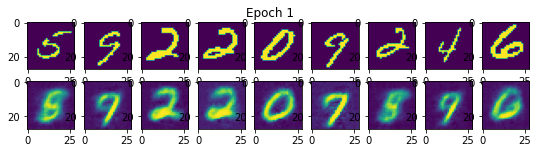

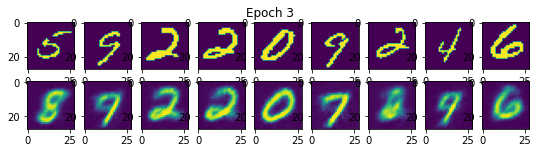

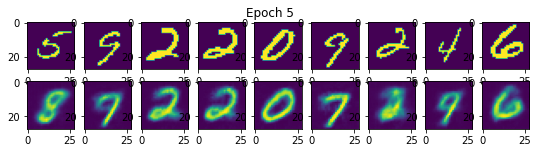

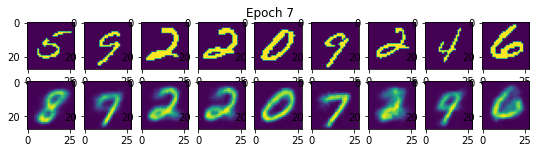

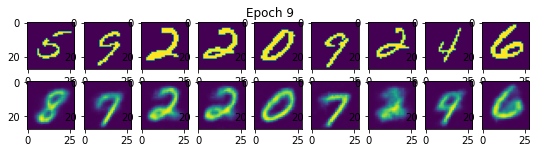

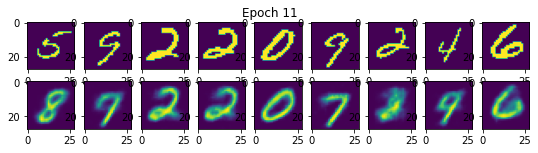

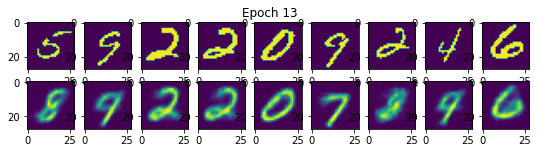

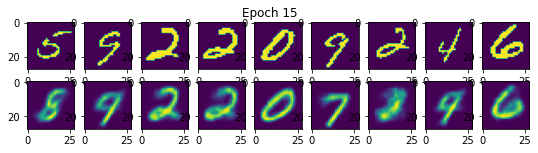

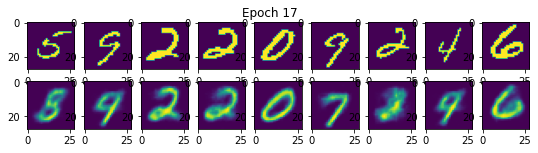

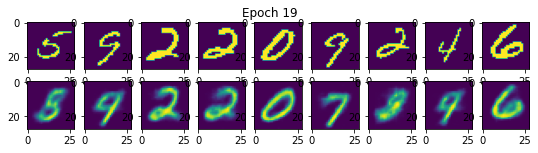

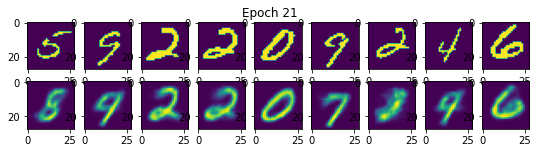

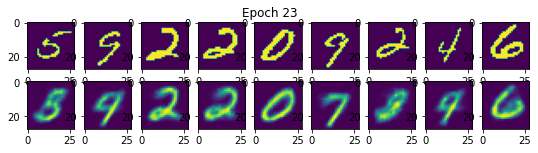

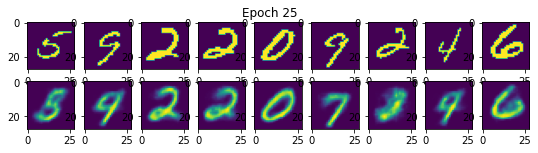

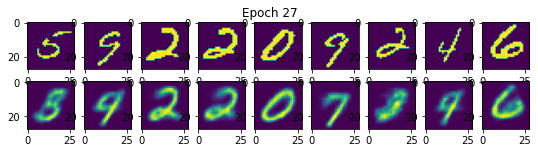

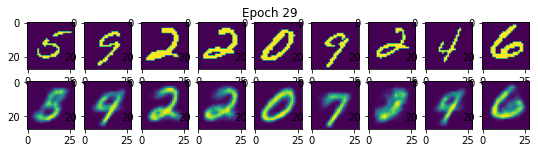

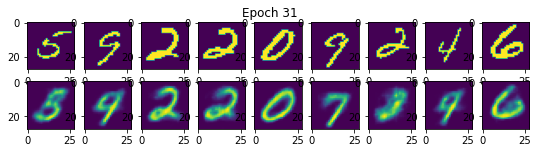

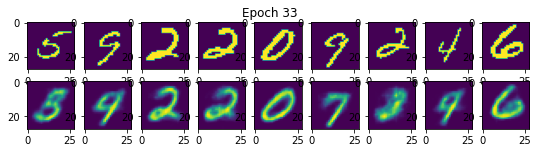

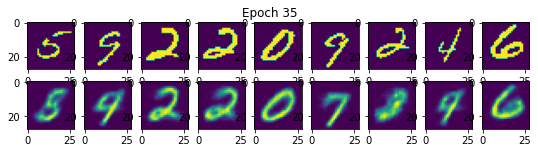

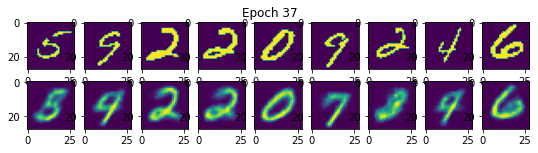

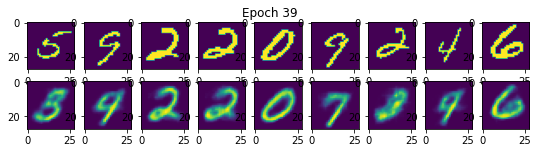

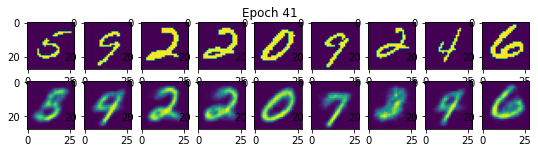

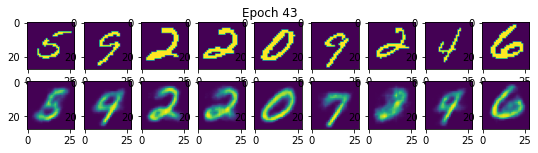

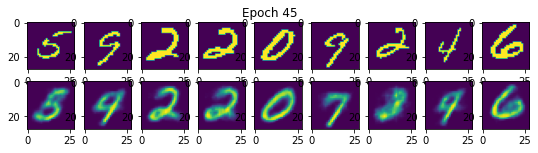

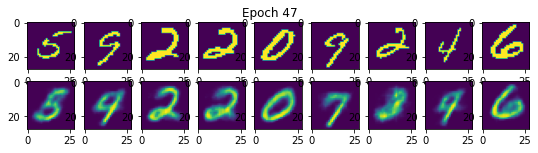

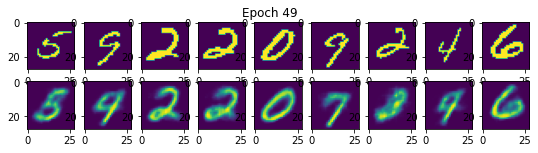

In [67]:
model.fit(gen, epochs=50, visualize=True)

## Test set

In [43]:
test_set = gen.get_full_data_set(training = False)
test_img, test_cls = test_set

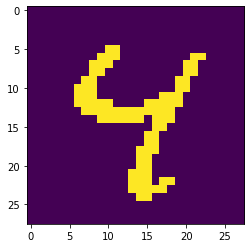

In [7]:
plt.imshow(test_img[6].astype(np.float32))

In [8]:
encoded = model.encode(test_img)

In [9]:
encoded.shape

torch.Size([10000, 16])

In [10]:
decoded = model.decode(encoded)

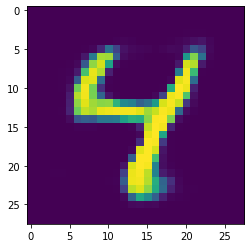

In [11]:
plt.imshow(decoded[6][0])

## Evaluation

In [12]:
net = VerificationNet("./models/verification_model")

In [13]:
decoded = decoded.squeeze(1)
decoded = np.expand_dims(decoded, axis=-1)

In [14]:
decoded.shape

(10000, 28, 28, 1)

In [15]:
net.predict(decoded)

313/313 [==============================] - 6s 18ms/step


(array([7., 2., 1., ..., 4., 5., 6.]),
 array([0.9999783 , 0.99957901, 0.99999464, ..., 0.99999714, 0.99346691,
        0.99999976]))

In [16]:
predictability, accuracy = net.check_predictability(data = decoded, correct_labels = test_cls)

313/313 [==============================] - 5s 17ms/step


In [17]:
print(f"Predictability is {predictability}. Accuracy is {accuracy}")

Predictability is 0.9582. Accuracy is 0.9413


# Autoencoder as generative model

In [46]:
encoded = model.encode(test_img)

In [72]:
generated_imgs = model.generate(10)

In [73]:
generated_imgs.shape

(10, 1, 28, 28)

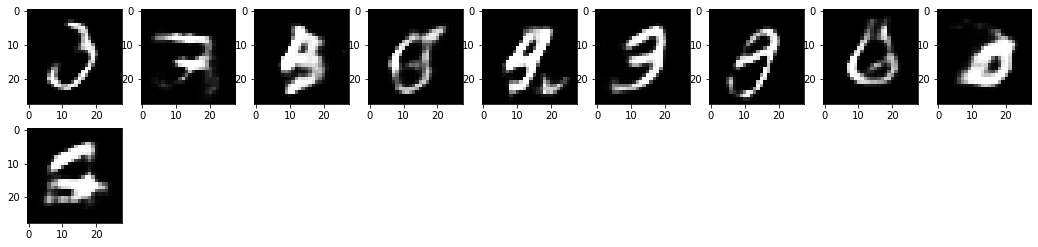

In [74]:
plt.figure(figsize=(18,4))
for i, item in enumerate(generated_imgs):
    plt.subplot(2,9,i+1)
    plt.imshow(np.transpose(item, (1, 2, 0)).astype(np.float), cmap="gray") 

In [97]:
generated_imgs = model.generate(10000)
generated_imgs = generated_imgs.squeeze(1)
generated_imgs = np.expand_dims(generated_imgs, axis=-1)
net.check_predictability(data = generated_imgs)
coverage = net.check_class_coverage(data=generated_imgs, tolerance=.8)
print(f"Predictability is {predictability}. Coverage is {coverage}")

313/313 [==============================] - 6s 18ms/step
Predictability is 0.6. Coverage is 1.0


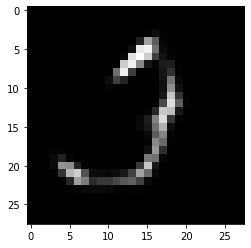

In [88]:
plt.imshow(generated_imgs[120].astype(np.float32), cmap="gray")

# Autoencoder as anomaly detector

In [2]:
gen_miss = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=10)
model_miss = Autoencoder_cnn(n_channels=1, criterion=nn.BCELoss(),latent_dim=16)
model_miss.fit(gen_miss, epochs=16, visualize=True)

In [5]:
test_set = gen_miss.get_full_data_set(training = False)
test_img, test_cls = test_set

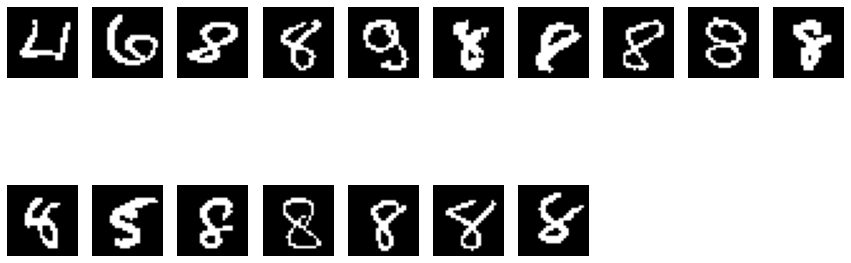

In [15]:
anomalies = model_miss.get_anomalious_imgs(test_img,test_cls,rule ="2-sigma",show_random=True, n_random=17)

### Evaluation of anomaly detector

In [16]:
anm_imgs, anm_cls = anomalies

In [21]:
TP = anm_cls[anm_cls==8].shape[0]/test_cls[test_cls==8].shape[0]
FP = anm_cls[anm_cls!=8].shape[0]/test_cls[test_cls!=8].shape[0]
#FN are 8-s in the dataset, but you failed to identify them.
FN = (test_cls[test_cls==8].shape[0]-anm_cls[anm_cls==8].shape[0])/test_cls[test_cls==8].shape[0]
print(f"TP = {TP:.4f}. FP={FP:.4f}. FN = {FN:.4f}")

## Stacked 

In [22]:
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

In [23]:
train_img, train_cls = gen.get_full_data_set(training = True)

In [24]:
train_img[0].shape

(28, 28, 3)

In [25]:
train_cls[2]

601

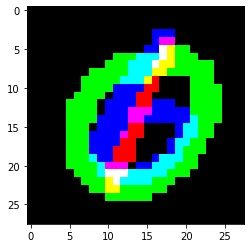

In [26]:
plt.imshow(train_img[2].astype(np.float))

Epoch:1, Loss:0.3009
Epoch:2, Loss:0.2016
Epoch:3, Loss:0.1562
Epoch:4, Loss:0.1310
Epoch:5, Loss:0.1163
Epoch:6, Loss:0.1069
Epoch:7, Loss:0.1005
Epoch:8, Loss:0.0959
Epoch:9, Loss:0.0927
Epoch:10, Loss:0.0905
Epoch:11, Loss:0.0889
Epoch:12, Loss:0.0874
Epoch:13, Loss:0.0865
Epoch:14, Loss:0.0858
Epoch:15, Loss:0.0851
Epoch:16, Loss:0.0846
Epoch:17, Loss:0.0840
Epoch:18, Loss:0.0833
Epoch:19, Loss:0.0828
Epoch:20, Loss:0.0824


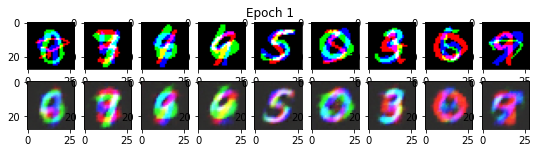

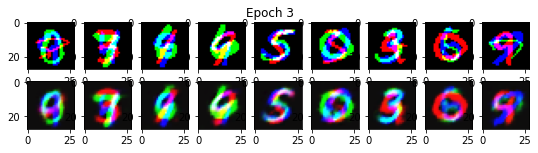

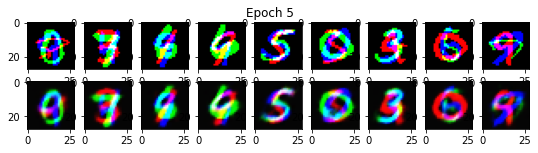

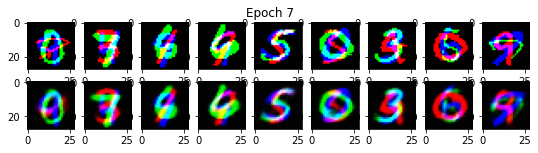

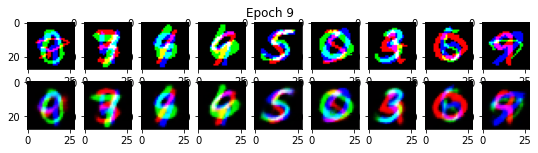

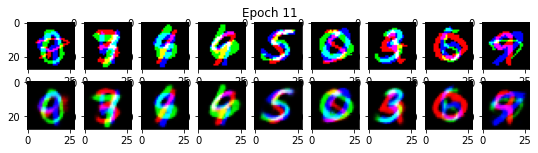

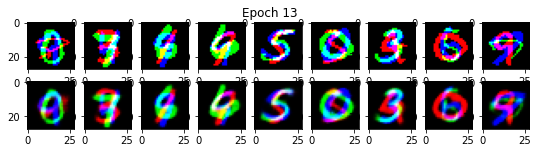

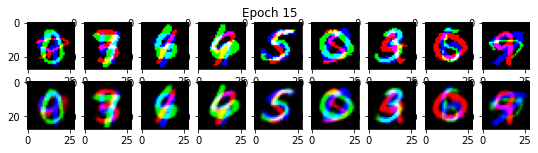

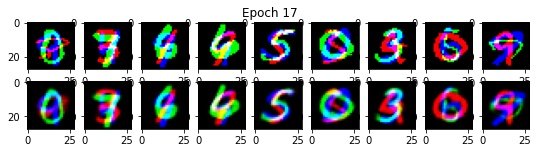

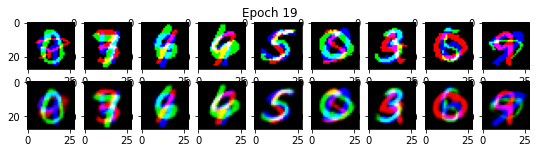

In [27]:
model_rgb = Autoencoder_cnn(n_channels=3,criterion=nn.BCELoss(), latent_dim=64)
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=64)
model_rgb.fit(gen, epochs=20, visualize=True)

## Test set

In [28]:
test_set = gen.get_full_data_set(training = False)

In [29]:
test_img, test_cls = test_set

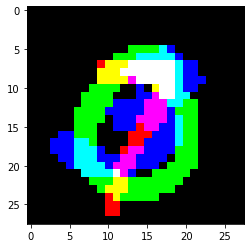

In [30]:
plt.imshow(test_img[4].astype(np.float))

In [31]:
test_cls[5]

503

In [32]:
encoded = model_rgb.encode(test_img)

In [33]:
encoded.shape

torch.Size([10000, 64])

In [34]:
decoded = model_rgb.decode(encoded)

In [35]:
decoded[5].shape

(3, 28, 28)

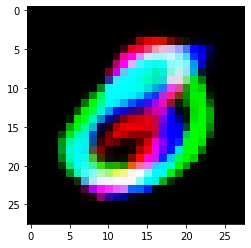

In [36]:
plt.imshow(decoded[5].transpose((1,2,0)))
plt.show()

In [37]:
decoded.transpose((0,2,3,1)).shape

(10000, 28, 28, 3)

In [38]:
predictability, accuracy = net.check_predictability(data = decoded.transpose((0,2,3,1)), correct_labels = test_cls)

313/313 [==============================] - 5s 17ms/step


In [39]:
print(f"Predictability is {predictability}. Accuracy is {accuracy}")

Predictability is 0.806. Accuracy is 0.7396


# AE as generative model

In [40]:
encoded.shape

torch.Size([10000, 64])

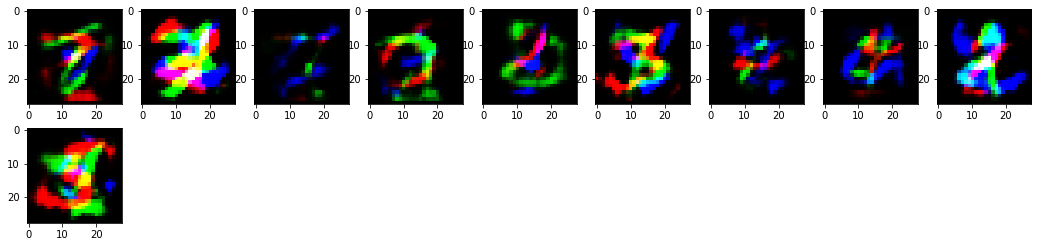

In [89]:
generated_imgs = model_rgb.generate(10)
plt.figure(figsize=(18,4))
for i, item in enumerate(generated_imgs):
    plt.subplot(2,9,i+1)
    plt.imshow(np.transpose(item, (1, 2, 0)).astype(np.float)) 

In [98]:
generated_imgs = model_rgb.generate(100000)
net.check_predictability(data = generated_imgs.transpose((0,2,3,1)))
coverage = net.check_class_coverage(data=generated_imgs.transpose((0,2,3,1)), tolerance=.8)
print(f"Predictability is {predictability}. Coverage is {coverage}")

3125/3125 [==============================] - 59s 19ms/step
Predictability is 0.6. Coverage is 0.769


# Stacked AE as Anomaly Detector

Epoch:1, Loss:0.3570
Epoch:2, Loss:0.2532
Epoch:3, Loss:0.2018
Epoch:4, Loss:0.1732
Epoch:5, Loss:0.1503
Epoch:6, Loss:0.1362
Epoch:7, Loss:0.1271
Epoch:8, Loss:0.1209
Epoch:9, Loss:0.1155
Epoch:10, Loss:0.1113
Epoch:11, Loss:0.1089
Epoch:12, Loss:0.1072
Epoch:13, Loss:0.1062
Epoch:14, Loss:0.1045
Epoch:15, Loss:0.1028
Epoch:16, Loss:0.1013
Epoch:17, Loss:0.1000
Epoch:18, Loss:0.0992
Epoch:19, Loss:0.0982
Epoch:20, Loss:0.0973


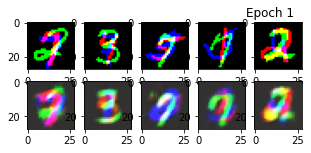

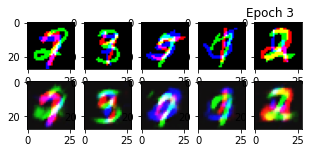

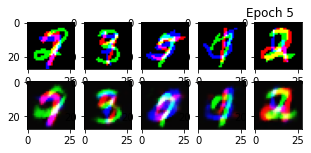

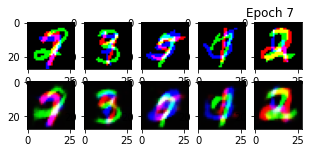

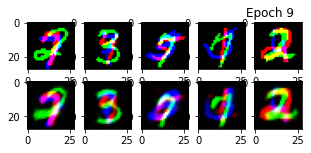

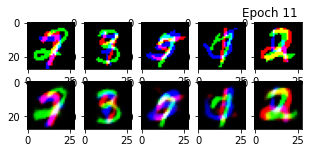

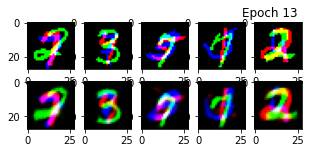

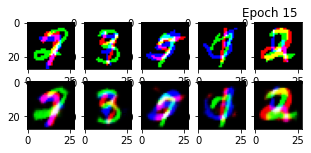

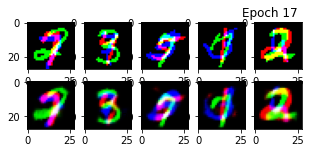

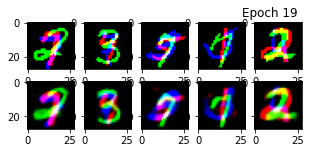

In [23]:
gen_miss_stacked = StackedMNISTData(mode=DataMode.COLOR_BINARY_MISSING, default_batch_size=10)
model_miss_stacked = Autoencoder_cnn(n_channels=3, criterion=nn.BCELoss(),latent_dim=64)
model_miss_stacked.fit(gen_miss_stacked, epochs=20, visualize=True)

In [24]:
test_set = gen_miss_stacked.get_full_data_set(training = False)
test_img, test_cls = test_set

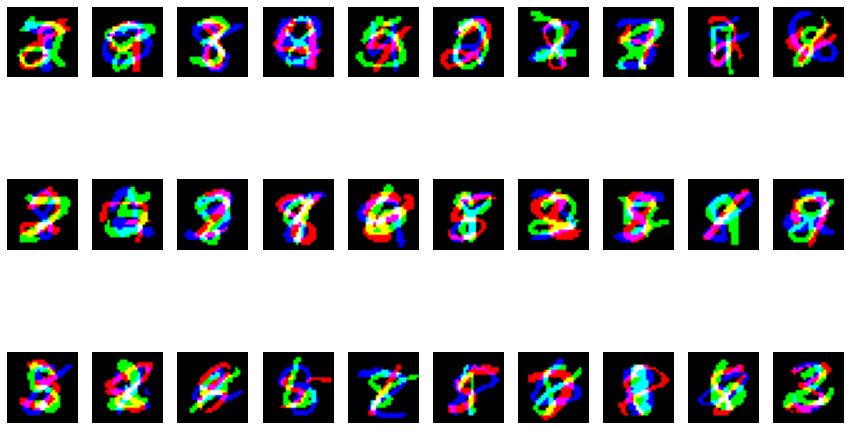

In [28]:
anomalies = model_miss_stacked.get_anomalious_imgs(test_img,test_cls,rule ="2-sigma",show_random=True, n_random=30)

### Evaluation of anomaly detector


In [29]:
anm_imgs, anm_cls = anomalies

In [55]:
def contains_8(number):
    return (number // 100 == 8) | (number // 10 == 8) | (number %10 == 8)

In [57]:
#anm_cls[contains_8(anm_cls)]

In [64]:
TP = anm_cls[contains_8(anm_cls)].shape[0]/test_cls[contains_8(test_cls)].shape[0]
FN = (test_cls[contains_8(test_cls)].shape[0]-anm_cls[contains_8(anm_cls)].shape[0])/test_cls[contains_8(test_cls)].shape[0]
print(f"TP = {TP:.4f}. FN = {FN:.4f}")

TP = 0.1041. FN = 0.8959
